In [1]:
import pandas as pd
from collections import Counter
import time
import matplotlib.pyplot as plt
from memory_profiler import memory_usage
# from fruithut.fruithut import *
# from mushroom.mushroom import *
# from foodmart.foodmart import *
# from chess.chess import *
from demo_web.demo_web import *


In [2]:
# sample
# data = {
#     'Tid': ['T1', 'T2', 'T3', 'T4', 'T5', 'T6'],
#     'Items': [['a', 'c', 'd'],
#               ['a', 'b', 'd'],
#               ['b', 'c', 'd', 'e'],
#               ['a', 'd'],
#               ['c', 'd', 'e'],
#               ['a', 'b', 'c', 'd', 'e']]
# }
# df = pd.DataFrame(data)

# data = {
#     'Tid': ['T1', 'T2', 'T3', 'T4', 'T5', 'T6'],
#     'Items': [['apple', 'cherry', 'durian'],
#               ['apple', 'banana', 'durian'],
#               ['banana', 'cherry', 'durian', 'elderberry'],
#               ['apple', 'durian'],
#               ['cherry', 'durian', 'elderberry'],
#               ['apple', 'banana', 'cherry', 'durian', 'elderberry']]
# }

# df = pd.DataFrame(data)
df['Item_Length'] = df['Items'].apply(lambda items: len(items))
len_df = len(df)
df

,Tid,Items,Item_Length
0,T8,"[item13, item12, item24, item27, item28, item1...",9
1,T10,"[item13, item26, item24, item12, item27, item2...",10
2,T11,"[item13, item26, item12, item24, item27, item1...",10
3,T12,"[item13, item26, item24, item12, item28, item1...",9
4,T13,"[item13, item26, item24, item12, item28, item1...",9
...,...,...,...
122,T134,"[item12, item10]",2
123,T135,"[item24, item12, item23]",3
124,T136,[item23],1
125,T137,"[item13, item26, item28, item27]",4


In [3]:
unique_items = df['Items'].explode().unique().tolist() # get unique item => save to list
unique_items

['item13',
 'item12',
 'item24',
 'item27',
 'item28',
 'item10',
 'item25',
 'item11',
 'item23',
 'item26',
 'item14']

In [4]:
length_transaction = df["Items"].apply(len)
if length_transaction.nunique() == 1:
    hastheSameLengh = True
else:
    hastheSameLengh = False

hastheSameLengh

False

In [5]:
length_transaction = length_transaction.to_list()
length_transaction

[9,
 10,
 10,
 9,
 9,
 9,
 11,
 9,
 9,
 9,
 9,
 9,
 9,
 11,
 10,
 9,
 11,
 7,
 8,
 9,
 7,
 6,
 5,
 7,
 7,
 8,
 8,
 8,
 7,
 9,
 9,
 8,
 11,
 10,
 11,
 11,
 11,
 11,
 7,
 7,
 7,
 8,
 6,
 9,
 8,
 5,
 4,
 5,
 5,
 4,
 3,
 4,
 4,
 4,
 4,
 5,
 5,
 4,
 4,
 4,
 4,
 2,
 3,
 3,
 5,
 2,
 3,
 2,
 2,
 5,
 3,
 4,
 2,
 6,
 4,
 3,
 2,
 3,
 4,
 1,
 4,
 3,
 3,
 3,
 3,
 5,
 2,
 2,
 4,
 4,
 1,
 2,
 2,
 2,
 4,
 3,
 4,
 4,
 1,
 1,
 5,
 4,
 2,
 3,
 6,
 2,
 4,
 4,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 4,
 1,
 3,
 5,
 3,
 4,
 3,
 2,
 3,
 1,
 4,
 4]

In [6]:
# calculate stset: {'a': [T1, T2, T4, T6]} - list Tid containing unique item
def cal_stset(df):
    # stset = {} 
    # for item in unique_items:
    #     tid_list = df[df['Items'].apply(lambda items: item in items)]['Tid'].tolist() # create column Items with items in unique item
    #     tid_lengths = [len(df[df['Tid'] == tid]['Items'].iloc[0]) for tid in tid_list if item in df[df['Tid'] == tid]['Items'].iloc[0]]
    #     stset[item] = {"StSet": tid_list, "Length_transaction": tid_lengths} # add value with item_key

    # df_stset = pd.DataFrame.from_dict(stset, orient = 'index').reset_index()
    # df_stset.columns = ["Items", "StSet", "Length_transaction"]
    # df_stset['Items'] = df_stset['Items'].apply(lambda x: [x]) 
    
    df_unpivot = df.explode('Items')
    df_stset = df_unpivot.groupby('Items').agg({'Tid': [list], 'Item_Length': list}).reset_index()
    df_stset.columns = ['Items', 'StSet', 'Length_transaction']
    df_stset['Items'] = df_stset['Items'].apply(lambda x: [x])
    df_stset
    return df_stset

In [7]:
# calculate support - count number of Tid containing unique item
def cal_support(df_stset):
    df_stset['Support'] = df_stset['StSet'].apply(len)
    return df_stset

In [8]:
start_time = time.time()
df_stset = cal_stset(df)
print(df_stset)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

       Items                                              StSet  \
0   [item10]  [T8, T10, T11, T13, T14, T18, T20, T21, T22, T...   
1   [item11]  [T8, T11, T12, T13, T14, T18, T21, T22, T23, T...   
2   [item12]  [T8, T10, T11, T12, T13, T14, T18, T19, T20, T...   
3   [item13]  [T8, T10, T11, T12, T13, T14, T18, T19, T20, T...   
4   [item14]  [T10, T11, T12, T13, T18, T19, T20, T21, T24, ...   
5   [item23]  [T8, T10, T11, T14, T18, T19, T20, T21, T22, T...   
6   [item24]  [T8, T10, T11, T12, T13, T14, T18, T19, T20, T...   
7   [item25]  [T8, T10, T11, T12, T13, T14, T18, T19, T20, T...   
8   [item26]  [T10, T11, T12, T13, T14, T18, T19, T20, T22, ...   
9   [item27]  [T8, T10, T11, T12, T14, T18, T19, T21, T22, T...   
10  [item28]  [T8, T10, T12, T13, T18, T19, T20, T21, T22, T...   

                                   Length_transaction  
0   [9, 10, 10, 9, 9, 11, 9, 9, 9, 9, 9, 11, 10, 9...  
1   [9, 10, 9, 9, 9, 11, 9, 9, 9, 9, 11, 10, 9, 11...  
2   [9, 10, 10, 9, 9, 9, 11

In [9]:
df_stset = cal_support(df_stset)
df_stset

,Items,StSet,Length_transaction,Support
0,[item10],"[T8, T10, T11, T13, T14, T18, T20, T21, T22, T...","[9, 10, 10, 9, 9, 11, 9, 9, 9, 9, 9, 11, 10, 9...",58
1,[item11],"[T8, T11, T12, T13, T14, T18, T21, T22, T23, T...","[9, 10, 9, 9, 9, 11, 9, 9, 9, 9, 11, 10, 9, 11...",59
2,[item12],"[T8, T10, T11, T12, T13, T14, T18, T19, T20, T...","[9, 10, 10, 9, 9, 9, 11, 9, 9, 9, 9, 9, 9, 11,...",61
3,[item13],"[T8, T10, T11, T12, T13, T14, T18, T19, T20, T...","[9, 10, 10, 9, 9, 9, 11, 9, 9, 9, 11, 10, 11, ...",59
4,[item14],"[T10, T11, T12, T13, T18, T19, T20, T21, T24, ...","[10, 10, 9, 9, 11, 9, 9, 9, 9, 11, 10, 9, 11, ...",62
5,[item23],"[T8, T10, T11, T14, T18, T19, T20, T21, T22, T...","[9, 10, 10, 9, 11, 9, 9, 9, 9, 9, 11, 10, 9, 1...",61
6,[item24],"[T8, T10, T11, T12, T13, T14, T18, T19, T20, T...","[9, 10, 10, 9, 9, 9, 11, 9, 9, 9, 9, 9, 11, 10...",53
7,[item25],"[T8, T10, T11, T12, T13, T14, T18, T19, T20, T...","[9, 10, 10, 9, 9, 9, 11, 9, 9, 9, 9, 9, 9, 11,...",65
8,[item26],"[T10, T11, T12, T13, T14, T18, T19, T20, T22, ...","[10, 10, 9, 9, 9, 11, 9, 9, 9, 9, 9, 11, 10, 9...",61
9,[item27],"[T8, T10, T11, T12, T14, T18, T19, T21, T22, T...","[9, 10, 10, 9, 9, 11, 9, 9, 9, 9, 9, 11, 9, 11...",59


In [10]:
# ex: 'a': {'l(a)': [2, 3, 5], 'n(a)': [1, 2, 1]}
def df_prepare_UBO(df_stset):
    l_item_list = []
    n_item_list = []
    for index, row in df_stset.iterrows():
        item = row['Items']
        length_transaction = row['Length_transaction']

        l_item = sorted(set(length_transaction)) # get unique len(Tid) => sort ascending

        counter = Counter(length_transaction)
        n_item = [counter[i] for i in l_item] # count unique len(Tid) in occupancy_list => same index with l_item
        
        l_item_list.append(l_item)
        n_item_list.append(n_item)
    
    df_stset = df_stset.assign(l_item=l_item_list, n_item=n_item_list)
    return df_stset

In [11]:
# calculate occupancy - O(P) = ∑ T ∈ STSet(P) |P|/|T|
# |P|: len(unique item) itemset {a} =>1
# |T|: len(Tid) 1/3 + 1/3 + 1/2 + 1/5 
def cal_occupancy(df_stset):
    occupancy_data = []
    for index, row in df_stset.iterrows():
        item = row['Items']
        length_transaction = row['Length_transaction']
        total = 0
        for length in length_transaction:
            total += len(item) / length
        occupancy_data.append({'Items': item, 'Occupancy': round(total, 2)})
    
    df_occupancy = pd.DataFrame(occupancy_data)
    df_stset['Occupancy'] = df_occupancy['Occupancy']
    return df_stset

In [12]:
df_stset = cal_occupancy(df_stset)
df_stset

,Items,StSet,Length_transaction,Support,Occupancy
0,[item10],"[T8, T10, T11, T13, T14, T18, T20, T21, T22, T...","[9, 10, 10, 9, 9, 11, 9, 9, 9, 9, 9, 11, 10, 9...",58,10.09
1,[item11],"[T8, T11, T12, T13, T14, T18, T21, T22, T23, T...","[9, 10, 9, 9, 9, 11, 9, 9, 9, 9, 11, 10, 9, 11...",59,11.55
2,[item12],"[T8, T10, T11, T12, T13, T14, T18, T19, T20, T...","[9, 10, 10, 9, 9, 9, 11, 9, 9, 9, 9, 9, 9, 11,...",61,12.67
3,[item13],"[T8, T10, T11, T12, T13, T14, T18, T19, T20, T...","[9, 10, 10, 9, 9, 9, 11, 9, 9, 9, 11, 10, 11, ...",59,11.86
4,[item14],"[T10, T11, T12, T13, T18, T19, T20, T21, T24, ...","[10, 10, 9, 9, 11, 9, 9, 9, 9, 11, 10, 9, 11, ...",62,11.93
5,[item23],"[T8, T10, T11, T14, T18, T19, T20, T21, T22, T...","[9, 10, 10, 9, 11, 9, 9, 9, 9, 9, 11, 10, 9, 1...",61,12.41
6,[item24],"[T8, T10, T11, T12, T13, T14, T18, T19, T20, T...","[9, 10, 10, 9, 9, 9, 11, 9, 9, 9, 9, 9, 11, 10...",53,8.55
7,[item25],"[T8, T10, T11, T12, T13, T14, T18, T19, T20, T...","[9, 10, 10, 9, 9, 9, 11, 9, 9, 9, 9, 9, 9, 11,...",65,12.97
8,[item26],"[T10, T11, T12, T13, T14, T18, T19, T20, T22, ...","[10, 10, 9, 9, 9, 11, 9, 9, 9, 9, 9, 11, 10, 9...",61,11.61
9,[item27],"[T8, T10, T11, T12, T14, T18, T19, T21, T22, T...","[9, 10, 10, 9, 9, 11, 9, 9, 9, 9, 9, 11, 9, 11...",59,11.10


In [13]:
# calculate according to the formula: ni x lx/li
def cal_ubo(l, n):
    total = 0
    for i in range(len(l)):
        total += n[i] * l[0] / l[i]
    return round(total, 2)

In [14]:
# summarize: ∑ni x lx/li => save to list 
def ubo_final(length, number_transaction):
    ubo = []
    for i in range(len(length)): 
        # ex: len = [2,3,5], num_trans = [1,2,1]
        # i = 0 => len = [2,3,5], num_trans = [1,2,1]
        # i = 1 => len = [3,5], num_trans = [2,1]
        # ...
        ubo.append(cal_ubo(length[i:], number_transaction[i:])) # save result cal_ubo for each i => get maxUBO
    return ubo

In [15]:
# get max from summarize => save max value in UBO by key
def calculate_maxUBO(df_UBO):
    df_UBO['List_UBO'] = None # create new column
    df_UBO['Max_UBO'] = None # create new column
    for index, row in df_UBO.iterrows():
        length = row['l_item'] #get list of len(Tid) containing unique item
        number_transaction = row['n_item'] # count unique len(Tid) in occupancy_list
        
        ubo = ubo_final(length, number_transaction) # get list of UBO by i. ex: [2.73, 2.6, 1.0]
        max_ubo = max(ubo) # max list of UBO
        
        df_UBO.at[index, 'List_UBO'] = ubo # save result in df
        df_UBO.at[index, 'Max_UBO'] = max_ubo # save result in df
        
    return df_UBO

In [16]:
# UBO calculation methods: main function
def cal_UBO(df_stset): 
    df_stset = df_prepare_UBO(df_stset)    
    df_stset = calculate_maxUBO(df_stset)
    return df_stset

In [17]:
df_stset = cal_UBO(df_stset)
df_stset.to_csv(r"E:\test.csv")

In [18]:
def mine_hoi_1_itemset(threshold, hastheSameLengh, df_stset):
    C1 = []
    HOI1 = []
    for index, row in df_stset.iterrows():
        item = row['Items'] # 1-itemset in row
        support = row['Support'] # support of 1-itemset
        occupancy = row['Occupancy'] # occuopancy of 1-itemset
        max_ubo = row['Max_UBO'] # max_ubo of 1-itemset
        
        if support >= threshold:
            if hastheSameLengh is False:
                if max_ubo >= threshold:
                    C1.append(item)
                    if occupancy >= threshold:
                        HOI1.append(item)
            else:
                C1.append(item)
                if occupancy >= threshold:
                    HOI1.append(item)
    
    return C1, HOI1

In [19]:
def df_intersection(items1, items2, df_stset):    
    df_intersection = pd.DataFrame(columns=['Items', 'StSet'])
    # set1 = set(items1)
    # set2 = set(items2)
    list_item = list(set(items1) | set(items2))
    
    list_occupancy_item = []
    
    for i in list_item:
        list_occupancy_item.append(df_stset[df_stset['Items'].apply(lambda item: i in item)]["StSet"].iloc[0])
        
    intersection_list = set(list_occupancy_item[0])
    for sublist in list_occupancy_item[1:]:
        intersection_list = intersection_list.intersection(sublist)
    
    df_intersection = df_intersection.append({'Items': list_item, 'StSet': intersection_list}, ignore_index=True)
    df_intersection['Length_transaction'] = df_intersection['StSet'].apply(lambda x: sorted([len(df[df['Tid'] == tid]['Items'].iloc[0]) for tid in x]))
    
    # list_length = df_intersection['StSet'].apply(lambda x: [len(df[df['Tid'] == tid]['Items'].iloc[0]) for tid in x]).iloc[0]
    # sort_data = sorted(zip(intersection_list, list_length))
    
    return df_intersection

In [20]:
# test1 = ['c']
# test2 = ['d']
# df_intersection(test1, test2, df_stset)

In [21]:
def is_same_equivalence_class(P1, P2):
    if len(P1) == len(P2):
        if len(P1) == 1:
            if P1 == P2:
                return False
            else:
                return True
        else:
            if P1 == P2:
                return False
            else:
                new_P1 = P1[:-1]
                new_P2 = P2[:-1]
                if new_P1 == new_P2:
                    return True
                else:
                    return False
    else:
        return False
        # else:
        #     intersection_P1_P2 = sorted(list(set(P1) & set(P2)))
        #     print(intersection_P1_P2)
        #     if len(intersection_P1_P2) == len(P1) - 1:
        #         for element in intersection_P1_P2:
        #             if P1.index(element) != P2.index(element):
        #                 return False
        #         return True
        #     else:
        #         return False

In [22]:
# test1 = ['a']
# test2 = ['b']
# print(is_same_equivalence_class(test1, test2))

In [23]:
def cal_occupancy_candidate(items):    
    df_candidate = pd.DataFrame(columns=['Items', 'StSet'])
    
    list_stset_item = []
    
    for i in items:
        list_stset_item.append(df_stset[df_stset['Items'].apply(lambda item: i in item)]["StSet"].iloc[0])
        
    intersection_list = set(list_stset_item[0])
    for sublist in list_stset_item[1:]:
        intersection_list = intersection_list.intersection(sublist)
    
    intersection_list = sorted(intersection_list, key = lambda x: x[0])
    
    df_candidate = df_candidate.append({'Items': items, 'StSet': intersection_list}, ignore_index=True)
    df_candidate['Length_transaction'] = df_candidate['StSet'].apply(lambda x: [len(df[df['Tid'] == tid]['Items'].iloc[0]) for tid in x])
    df_candidate = cal_occupancy(df_candidate)
    return df_candidate
    

In [24]:
# test = ['a','b','d']
# df_test = cal_occupancy_candidate(test)['Occupancy'].iloc[0]
# print(df_test)

In [25]:
def mine_hoi_k_itemset(threshold, hastheSameLengh, CK_minus_1, df_stset):
    CK = []
    HOIK = []
    
    while len(CK_minus_1) > 0:
        # P1 = sorted(CK_minus_1[0])
        P1 = CK_minus_1[0]
        for P2 in CK_minus_1:
            try:
                if is_same_equivalence_class(P1, P2):
                    P = df_intersection(P1, P2, df_stset)
                    P_items = P['Items'].iloc[0]
                    P_stset = P['StSet'].iloc[0]
                    if len(P_stset) >= threshold:
                        if hastheSameLengh is False:
                            P_ubo = cal_UBO(P)['Max_UBO'].iloc[0]
                            if P_ubo >= threshold:
                                CK.append(P_items)
                        else:
                            CK.append(P_items)
            except:
                continue
                        
        CK_minus_1.pop(0)
    
    for i in CK:
        if cal_occupancy_candidate(i)['Occupancy'].iloc[0] >= threshold:
            HOIK.append(i)
            
    return CK, HOIK
        
                        
    

In [26]:
def mine_depth_hois(threshold, hastheSameLengh, C1, df_stset, HOIS):
    if len(C1) == 0:
        return HOIS
    
    for i in range(len(C1)):
        P1 = C1[i]
        C_l = []
        for j in range(i + 1, len(C1)):
            try:
                P2 = C1[j]
                P = df_intersection(P1, P2, df_stset)
                P_items = P['Items'].iloc[0]
                P_stset = P['StSet'].iloc[0]
                if len(P_stset) >= threshold:
                    if hastheSameLengh is False:
                        P_ubo = cal_UBO(P)['Max_UBO'].iloc[0]
                        if P_ubo >= threshold:
                            C_l.append(P_items)
                    else:
                        C_l.append(P_items)
            except:
                continue

        mine_depth_hois(threshold, hastheSameLengh, C_l, df_stset, HOIS)
        
        for i in C_l:
            if cal_occupancy_candidate(i)['Occupancy'].iloc[0] >= threshold:
                HOIS.append(i)
    
    # return HOIS
        
                        

In [27]:
#test FHOI
memory_before = memory_usage()[0]
HOIS = []
C1 = []
HOI1 = []
CK_minus_1 = []

k = 2 # loop to create 2-itemset
threshold_percent = 0.1
threshold = threshold_percent * len_df # ex: threshold = 25% of len(database)
start_time = time.time()

#create candidate 1 and HOI1 itemset
C1, HOI1 = mine_hoi_1_itemset(threshold, hastheSameLengh, df_stset)
HOIS = HOI1
CK_minus_1 = C1

while CK_minus_1:
    CK, HOIK = mine_hoi_k_itemset(threshold, hastheSameLengh, CK_minus_1, df_stset)
    if HOIK:
        for i in HOIK:
            HOIS.append(i)
        CK_minus_1 = CK
        k += 1
    else:
        continue
memory_after = memory_usage()[0]

for i in HOIS:
    print(i)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")
memory_used = memory_after - memory_before
print("Memory usage:", memory_used, "MiB")


['item25']
['item25', 'item12']
['item25', 'item12', 'item10']
Execution time: 15.944222211837769 seconds
Memory usage: 0.25 MiB


In [45]:
#test DFHOI
def test_dfhoi(threshold_list):
    start_time = time.time()


    execution_time_list = []
    len_itemset_list = []
    memory_usage_list = []
    
    for threshold_percent in threshold_list:
        memory_before = memory_usage()[0]
        HOIS = []
        C1 = []
        HOI1 = []

        # threshold_percent = i
        threshold = threshold_percent * len_df # ex: threshold = 25% of len(database)

        #create candidate 1 and HOI1 itemset
        C1, HOI1 = mine_hoi_1_itemset(threshold, hastheSameLengh, df_stset)
        HOIS = HOI1
        
        HOIS.append(mine_depth_hois(threshold, hastheSameLengh, C1, df_stset, HOIS))
        memory_after = memory_usage()[0]
        HOIS = list(filter(lambda x: x is not None, HOIS))
        
        for i in HOIS:
            print(i)
            
        end_time = time.time()
        execution_time = end_time - start_time
        memory_used = memory_after - memory_before
        print("Threshold: " + str(threshold_percent))
        print("Length HOI: " + str(len(HOIS)))
        print(f"Execution time: {execution_time} seconds")
        print("Memory usage:", str(memory_used), "MiB")
        print("--------------------")
        len_itemset_list.append(len(HOIS))
        execution_time_list.append(execution_time)
        memory_usage_list.append(memory_used)
    
    return len_itemset_list, execution_time_list, memory_usage_list


In [46]:
threshold_list = [0.08, 0.09, 0.1, 0.2]
test_dfhoi(threshold_list)

['item11']
['item12']
['item13']
['item14']
['item23']
['item25']
['item26']
['item27']
['item28']
['item27', 'item25', 'item11', 'item10']
['item27', 'item11', 'item10']
['item13', 'item26', 'item24', 'item12', 'item10', 'item14', 'item25']
['item14', 'item12', 'item25', 'item10']
['item23', 'item12', 'item25', 'item10']
['item12', 'item25', 'item28', 'item10']
['item25', 'item12', 'item10']
['item26', 'item24', 'item27', 'item10', 'item25', 'item23']
['item27', 'item25', 'item10', 'item23']
['item25', 'item10', 'item23']
['item12', 'item10']
['item23', 'item10']
['item25', 'item10']
['item13', 'item26', 'item24', 'item12', 'item25', 'item11']
['item26', 'item24', 'item12', 'item25', 'item11']
['item24', 'item12', 'item25', 'item11', 'item27']
['item24', 'item12', 'item25', 'item11']
['item26', 'item12', 'item28', 'item25', 'item11']
['item12', 'item25', 'item11', 'item27']
['item12', 'item28', 'item25', 'item11']
['item25', 'item11', 'item12']
['item13', 'item14', 'item26', 'item11']

([61, 13, 3, 0],
 [51.14729309082031, 89.34781885147095, 118.5958251953125, 119.9680323600769],
 [0.0, 0.0, 0.0, 0.0])

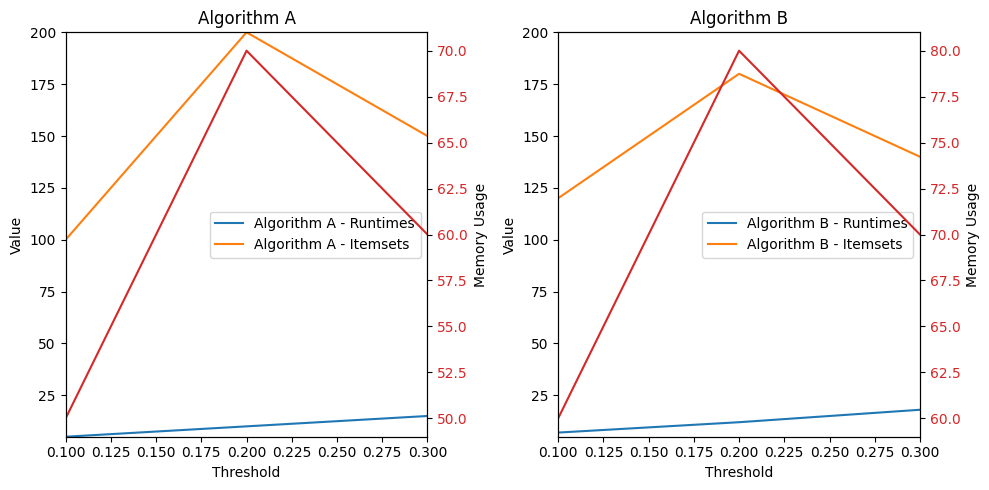

In [35]:
thresholds_A = [0.1, 0.2, 0.3]
runtimes_A = [5, 10, 15]
itemsets_A = [100, 200, 150]
memory_usage_A = [50, 70, 60]

thresholds_B = [0.1, 0.2, 0.3]
runtimes_B = [7, 12, 18]
itemsets_B = [120, 180, 140]
memory_usage_B = [60, 80, 70]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(thresholds_A, runtimes_A, label='Algorithm A - Runtimes')
ax1.plot(thresholds_A, itemsets_A, label='Algorithm A - Itemsets')
ax1.set_title('Algorithm A')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Value')
ax1.legend()

ax1_mem = ax1.twinx()
ax1_mem.plot(thresholds_A, memory_usage_A, label='Algorithm A - Memory Usage', color='tab:red')
ax1_mem.set_ylabel('Memory Usage')
ax1_mem.tick_params(axis='y', labelcolor='tab:red')

ax2.plot(thresholds_B, runtimes_B, label='Algorithm B - Runtimes')
ax2.plot(thresholds_B, itemsets_B, label='Algorithm B - Itemsets')
ax2.set_title('Algorithm B')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Value')
ax2.legend()

ax2_mem = ax2.twinx()
ax2_mem.plot(thresholds_B, memory_usage_B, label='Algorithm B - Memory Usage', color='tab:red')
ax2_mem.set_ylabel('Memory Usage')
ax2_mem.tick_params(axis='y', labelcolor='tab:red')

min_x = min(min(thresholds_A), min(thresholds_B))
max_x = max(max(thresholds_A), max(thresholds_B))
min_y = min(min(runtimes_A), min(itemsets_A), min(runtimes_B), min(itemsets_B), min(memory_usage_A), min(memory_usage_B))
max_y = max(max(runtimes_A), max(itemsets_A), max(runtimes_B), max(itemsets_B), max(memory_usage_A), max(memory_usage_B))
ax1.set_xlim(min_x, max_x)
ax1.set_ylim(min_y, max_y)
ax2.set_xlim(min_x, max_x)
ax2.set_ylim(min_y, max_y)

plt.tight_layout()
plt.show()